# Cluster weak lensing

Galaxy cluster weak lensing is used to find the total mass inside of a galaxy cluster. Stacked cluster lensing finds the average mass of the stack. In this example we will use the `ARTsampler` to sample the posterior of a 7-dimensional model of a stacked weak lensing analysis. We also have a chain from an original MCMC analysis (with `emcee`) that we can compare against.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.interpolate as interp
import ARTsampler
import resampler
import cluster_toolkit as ct
import scipy.stats
%matplotlib inline

In [2]:
#Plot configurations
plt.rc("text", usetex=True)
plt.rc("font", size=24, family="serif")
plt.rc("errorbar", capsize=3)

In [3]:
#Read in the chain and remove burn-in (which I only know is there for this example)
Npoints = 32*2500 #32 walkers
input_chain = np.loadtxt("chain_full_Y1_SAC_z0_l3.FORSAMPLER")[-Npoints:]
lnpost = np.loadtxt("likes_full_Y1_SAC_z0_l3.FORSAMPLER")[-Npoints:]
print("chain shape is  ", input_chain.shape)
print("lnpost shape is ", lnpost.shape)

chain shape is   (80000, 7)
lnpost shape is  (80000,)


# Step 0: set up a reconstruction of the posterior
For now, we won't use the _true_ posterior, but an ART reconstruction of the posterior.

In [4]:
#Load in the arguments that we will use
#Note: the file was pickled with python 2.7, so we have to encode
args = pickle.load(open("z0_l3_args.p", "rb"), encoding='latin1')

Marr = args["Marr"]
bias_arr = args["bias_arr"]
args["b_spline"] = interp.interp1d(Marr, bias_arr)

def clusterWL_lnpost(params, args):
    lM, c, tau, fmis, Am, B0, Rs = params
    
    if lM < 13.0 or lM > 16.0 or c <= 1.0 or c > 15.0 or Am <= 0.7\
        or tau <= 0.0  or fmis < 0.0 or fmis > 1.0: 
        return -1e99
    if B0 < 0.0 or B0 > 2. or Rs <=0.0 or  Rs > 10.: 
        return -1e99
    LPfmis = (0.32 - fmis)**2/0.05**2
    LPtau  = (0.153 - tau)**2/0.03**2
    LPA    = (1.021459904697847 - Am)**2/0.0006116071885671028
    
    lnlike = -0.5*(LPfmis + LPtau + LPA) #Sum of the priors
    
    h = args["h"]
    z = args["z"]
    inds = args["kept_inds"]
    r = args['r'] #Mpc/h comoving
    xi_nl = args['xi_nl']
    b_spline = args["b_spline"]
    Redges = args["Redges"] #Mpc/h comoving
    Rp = args['Rp'] #Mpc/h comoving; projected on the sky
    Rlam = args["Rlam"] #Mpc/h comoving
    lam = Rlam**5 * 100. #richness
    Sigma_crit_inv = args["Sigma_crit_inv"] #pc^2/hMsun comoving
    M = 10**lM
    Omega_m = 0.3 #CHECK THIS
    xi_nfw   = ct.xi.xi_nfw_at_r(r, M, c, Omega_m)
    bias = b_spline(M)
    xi_2halo = ct.xi.xi_2halo(bias, xi_nl)
    xi_hm    = ct.xi.xi_hm(xi_nfw, xi_2halo)
    Sigma  = ct.deltasigma.Sigma_at_R(Rp, r, xi_hm, M, c, Omega_m)
    DeltaSigma = ct.deltasigma.DeltaSigma_at_R(Rp, Rp, Sigma, M, c, Omega_m)
    Rmis = tau*Rlam #Mpc/h
    Sigma_mis  = ct.miscentering.Sigma_mis_at_R(Rp, Rp, Sigma, M, c, 
                                                Omega_m, Rmis, kernel="gamma")
    DeltaSigma_mis = ct.miscentering.DeltaSigma_mis_at_R(Rp, Rp, Sigma_mis)
    #Note: here, Rs is Mpc physical but Rp is Mpc/h comoving
    boost = ct.boostfactors.boost_nfw_at_R(Rp, B0, Rs*h*(1+z))
    full_Sigma = (1-fmis)*Sigma + fmis*Sigma_mis
    full_DeltaSigma = (1-fmis)*DeltaSigma + fmis*DeltaSigma_mis #miscentering
    full_DeltaSigma *= Am #multiplicative bias
    full_DeltaSigma /= boost #boost factor
    full_DeltaSigma /= (1-full_Sigma*Sigma_crit_inv) #reduced shear
    ave_DeltaSigma = ct.averaging.average_profile_in_bins(Redges, Rp, full_DeltaSigma)
    
    #print("ave DeltaSigma is:\n\t",ave_DeltaSigma)
    #print("SCI: ", Sigma_crit_inv)
    #print("halo bias: ", bias)
    DS_data = args["DeltaSigma"]
    Cov = args["Cov"]

    #Convert to Msun/pc^2 physical
    X = (DS_data - ave_DeltaSigma[inds]*h*(1+z)**2)
    lnlike += -0.5*np.dot(X, np.linalg.solve(Cov, X))
    
    Bp1 = args['Bp1']
    Bcov = args['Bcov']
    #Note: here, Rs is Mpc physical and Rb is the same
    boost_model = ct.boostfactors.boost_nfw_at_R(args['Rb'], B0, Rs)
    #print("boost model:", boost_model)
    Xb = Bp1 - boost_model
    lnlike += -0.5*np.dot(Xb, np.linalg.solve(Bcov, Xb))  
    return lnlike

In [5]:
params = np.array([14.662047841051441, 4.5, 0.153, 0.32, 1.02, 0.07, 2.49])
print(clusterWL_lnpost(params, args)) #answer = -9.33e+02
print(clusterWL_lnpost(input_chain[-1], args))
print(lnpost[-1])

-932.218592156464
-23.826624230510525
-16.822678640216633


# Step 1: set up the ART sampler
In order to set up the sampler, we need to guess the mean and covariance of the target distribution. I know roughly what the means should be, but for the covariance I'm just going to guess a Gaussian covariance with no correlations (i.e. diagonal), even though I know this is wrong.

In [6]:
#Parameters are: log{10}(M), concentration, tau_{miscentering}, f_{miscentering}
#A_m, B_0, R_s (see McClintock et al. 2019 for details)
#guess_mean = np.array([14.1, 6., .1, 0.25, 1.02, 0.2, 1.5])
#guess_cov = np.diag(np.var(input_chain, 0))
prior_volume = np.array([[13., 16.], #log10 M
                        [1., 15.], #concentration
                        [0.05, 0.4], #tau
                        [0.05, 0.6], #fmis
                        [0.88, 1.2], #Am
                        [0.1, 1.0], #B0
                        [0.1, 1.0]]) #Rs

In [7]:
prior_distributions = [scipy.stats.uniform(loc=13, scale=3), 
                       scipy.stats.uniform(loc=1, scale=14), 
                       scipy.stats.norm(loc=0.153, scale=0.03), 
                       scipy.stats.norm(loc=0.32, scale=0.05), 
                       scipy.stats.norm(loc=1.021459904697847, scale=0.024730693248817406), 
                       scipy.stats.uniform(loc=0.1, scale=0.9), 
                       scipy.stats.uniform(loc=0.1, scale=0.9)]

In [8]:
sampler = ARTsampler.ARTsampler(prior_distributions, clusterWL_lnpost, args, 
                                quiet=False, scale=7,
                                Ntraining_points=200, Nburn = 1000, Nsteps=2000, max_iter=1)

Maximizing True lnprob:
 final_simplex: (array([[13.98644534,  7.17719255,  0.16046253,  0.37789544,  1.01984714,
         0.34450457,  0.42646067],
       [13.98663373,  7.17819132,  0.16026537,  0.37783448,  1.0197562 ,
         0.34497753,  0.42593058],
       [13.9865925 ,  7.17826005,  0.16033414,  0.37796689,  1.01994906,
         0.34424444,  0.42681269],
       [13.98647205,  7.16783896,  0.16008233,  0.37796984,  1.01986696,
         0.34453171,  0.42657858],
       [13.98643717,  7.17542361,  0.1602521 ,  0.37792157,  1.01988747,
         0.34456384,  0.42642544],
       [13.98661594,  7.16852413,  0.16030897,  0.3778251 ,  1.01986685,
         0.34511957,  0.42588716],
       [13.98664933,  7.16785473,  0.16013428,  0.37797765,  1.01976045,
         0.34457298,  0.42640523],
       [13.98633442,  7.18423695,  0.16029732,  0.37786098,  1.01980091,
         0.34458239,  0.42656103]]), array([15.06337344, 15.06337712, 15.06339315, 15.06339394, 15.06342562,
       15.06346515, 1

Text(0, 0.5, '$c_{\\rm 200b}$')

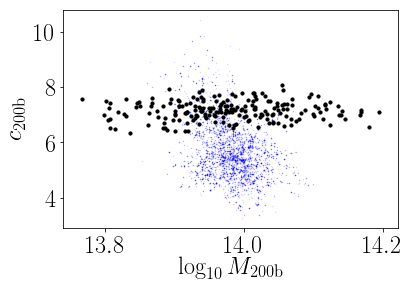

In [9]:
training_points = sampler.get_training_points()
plt.scatter(training_points[:,0], training_points[:,1], c='k', s=10, zorder=1)

plt.scatter(input_chain[:5000,0], input_chain[:5000,1], marker='.', c='b', 
            alpha=0.2, s=0.5, zorder=0)
plt.xlabel(r"$\log_{10}M_{\rm 200b}$")
plt.ylabel(r"$c_{\rm 200b}$")

# Step 2: do some iterations
Let's do two iterations to see how it does.

In [10]:
ind = 0
while sampler.single_iteration():
    print("On iteration {0}".format(ind))
    ind += 1
    continue

Performing iteration 0
Computing log-probability of training points.
Reconstructing the distribution
      fun: 286904.20227815775
 hess_inv: array([[2.38796722e-06]])
      jac: array([-4.09781933e-08])
  message: 'Optimization terminated successfully.'
     nfev: 7
      nit: 6
     njev: 7
   status: 0
  success: True
        x: array([2.94965415])
Running first burn-in
Running second burn-in
Running production...
On iteration 0
Performing iteration 1
Computing log-probability of training points.
Reconstructing the distribution
      fun: 1.283705098090307e+201
 hess_inv: array([[1]])
      jac: array([-3.74082968e+199])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 15
      nit: 0
     njev: 3
   status: 2
  success: False
        x: array([1.5040774])
Running first burn-in


/Users/tmcclintock/anaconda/envs/py36/lib/python3.6/site-packages/scipy/optimize/linesearch.py:155: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/Users/tmcclintock/anaconda/envs/py36/lib/python3.6/site-packages/scipy/optimize/linesearch.py:391: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


Running second burn-in
Running production...
On iteration 1
Iteration 2 reached, max_iter is 1.


Text(0, 0.5, '$y$')

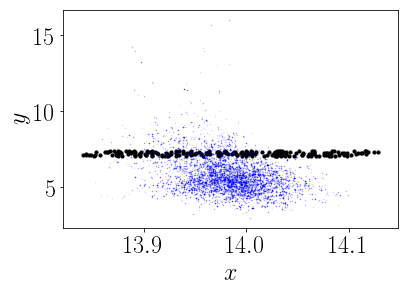

In [11]:
training_points = sampler.get_training_points()
plt.scatter(training_points[:,0], training_points[:,1], c='k', s=10, zorder=1)

samples = sampler.get_samples().T
plt.scatter(samples[0], samples[1], marker='.', c='r', alpha=0.2, s=0.5, zorder=0)

plt.scatter(input_chain[:10000,0], input_chain[:10000,1], marker='.', c='b', alpha=0.2, s=0.5)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")

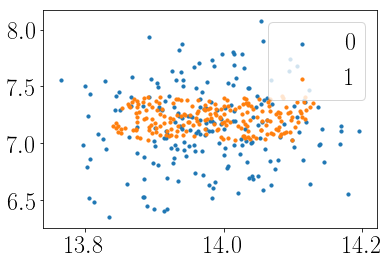

In [12]:
for i in range(0, 2):
    training_points = sampler.get_training_points(i)
    plt.scatter(training_points[:,0], training_points[:,1], s=10, label=i)
plt.legend()